In [16]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from models.non_constant_diffusivity import NonConstantDiffusivityNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from trainers.train import train_loop

In [17]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\non_linear\non_linear.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results\non_linear')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results\non_linear\model_paper')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear\model_paper


In [18]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\non_linear\non_linear.pkl


In [19]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [20]:
X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

In [21]:
# Arquitectura del modelo
input_shape = X_val[0].shape  # [1, 10, 8]
hidden1_dim = 150
hidden2_dim = 150
output_shape = y_val.values[0].shape  # [1, 10, 10]

In [22]:
# Se carga el modelo y el optimizador
model = NonConstantDiffusivityNeuralNetwork(input_shape, hidden1_dim, hidden2_dim, output_shape, n_filters=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=torch.device('cpu'))

In [23]:
def smooth_curve(data, window_size=200):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    # Imprimir los resultados
    print(f"Mínimo: {minimo:.2e}")
    print(f"Máximo: {maximo:.2e}")
    print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
    print(f"Mediana (Q2): {mediana:.2e}")
    print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")


def relative_error_return_Q(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))
    
    tercer_cuartil = np.percentile(prediction_error, 75)

    Q_bool = prediction_error <= tercer_cuartil

    return Q_bool

def relative_error(validation, prediction, dx=dx, dy=dy):
    return np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

def calculate_error(validation_data, predicted_data):
    numerator = np.trapz(np.trapz((validation_data - predicted_data)**2))
    denominator = np.trapz(np.trapz((validation_data)**2))

    if np.all(denominator == 0):
        result = np.sqrt(numerator)
    else:
        result = np.sqrt(numerator / denominator)
    return result

In [24]:
linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(16)
height = cm_to_in(8) 

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [25]:
y_pred, K_pred = model(X_val)

y_pred = TensOps(y_pred, space_dimension=2, contravariance=0, covariance=0)
K_pred = TensOps(K_pred, space_dimension=2, contravariance=0, covariance=0)

u_validation = y_val.values.detach()
u_prediction = y_pred.values.detach()

um_validation = zo.Mx(zo.My(y_val)).values.detach()
um_prediction = zo.Mx(zo.My(y_pred)).values.detach()

K_validation = zo.My(zo.Mx(K_val)).values.detach()
K_prediction = K_pred.values.detach()

qx_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qx_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qx_prediction = azo.scalar_product(K_pred, zo.Dx(y_pred, D)).values.detach()

qy_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qy_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qy_prediction = azo.scalar_product(K_pred, zo.Dy(y_pred, D)).values.detach()

In [26]:
def plot_boxplot_and_colormaps(validation_solution, predicted_solution, variable, problem):

    validation_solution = validation_solution[:, 0]
    predicted_solution = predicted_solution[:, 0]

    colors = sns.color_palette("hls", 8)
    
    solution_error = relative_error(validation=validation_solution, prediction=predicted_solution).squeeze()

    min = np.percentile(solution_error, 5)
    max = np.percentile(solution_error, 95)  
    min_index = np.argmin(np.abs(solution_error - min))
    max_index = np.argmin(np.abs(solution_error - max))

    # --------------------------------------------------------------------------------------

    plt.figure(figsize=(width/1.5, 2*height))

    sns.boxplot(y=solution_error, color=colors[4], width=0.4)  
    sns.stripplot(y=solution_error, color=colors[5], jitter=0.1, size=3, alpha=0.4, edgecolor='black', linewidth=0.11)
    plt.scatter(x=0, y=solution_error[min_index], color=colors[0], edgecolor='black', label='P5', zorder=4)
    plt.scatter(x=0, y=solution_error[max_index], color=colors[1], edgecolor='black', label='P95', zorder=4)

    plt.xlim(-0.5, 0.5)
    plt.ylabel('$E_r$', fontsize=label_fontsize)
    plt.yscale('log')
    plt.legend(loc='upper left', fontsize=legend_fontsize)
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_{problem}_boxplot.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

    # --------------------------------------------------------------------------------------

    combined_data = np.concatenate((validation_solution[min_index].numpy().flatten(), predicted_solution[min_index].numpy().flatten()))
    vmin = np.min(combined_data)
    vmax = np.max(combined_data)

    fig, axs = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'wspace': 0.4})
    plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom)  

    im1 = axs[0].imshow(validation_solution[min_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    im2 = axs[1].imshow(predicted_solution[min_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.set_xticks(np.arange(0, 1.1, 0.2))
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_{problem}_min.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

    # --------------------------------------------------------------------------------------

    combined_data = np.concatenate((validation_solution[max_index].numpy().flatten(), predicted_solution[max_index].numpy().flatten()))
    vmin = np.min(combined_data)
    vmax = np.max(combined_data)

    fig, axs = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'wspace': 0.4})
    plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom)  

    im1 = axs[0].imshow(validation_solution[max_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    im2 = axs[1].imshow(predicted_solution[max_index], cmap='viridis', interpolation='bicubic', vmin=vmin, vmax=vmax, extent=[0, 1, 0, 1])
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        ax.set_xticks(np.arange(0, 1.1, 0.2))
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_{problem}_max.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

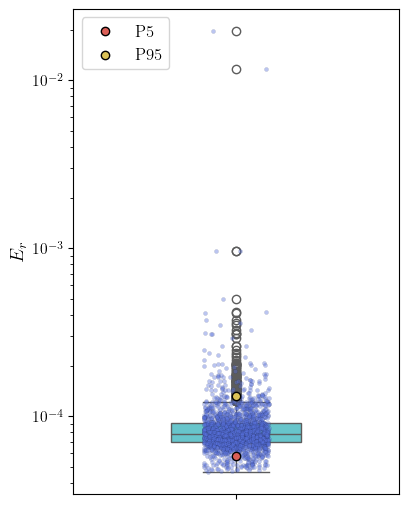

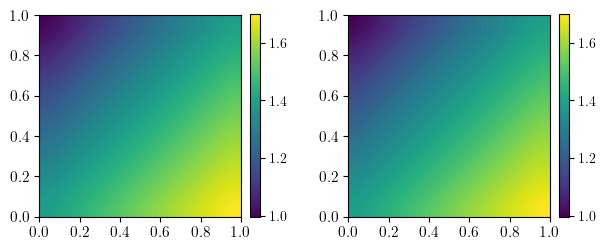

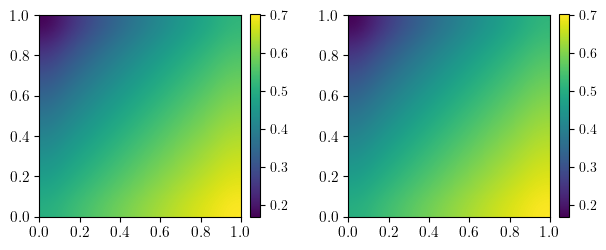

In [27]:
plot_boxplot_and_colormaps(validation_solution=u_validation, predicted_solution=u_prediction, variable='solution', problem='nonlinear_P4')

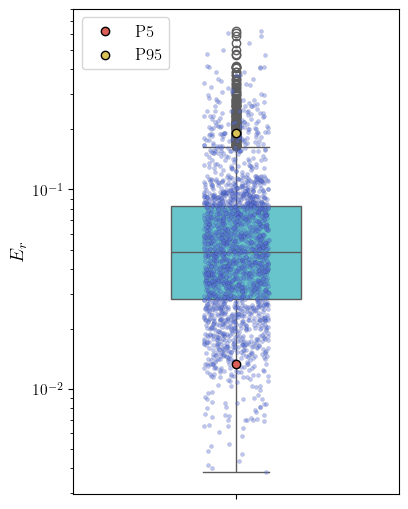

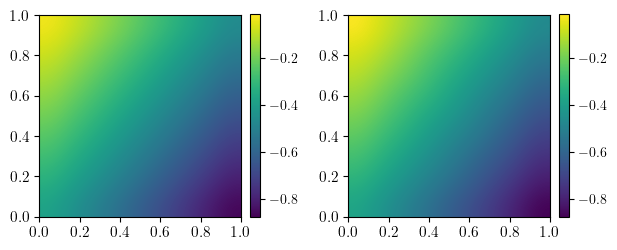

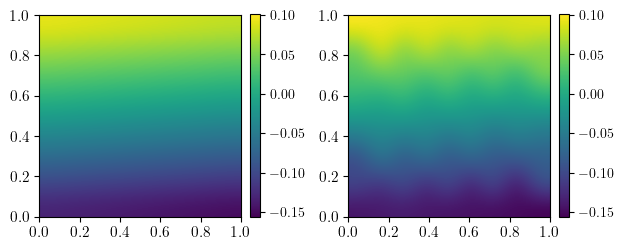

In [28]:
plot_boxplot_and_colormaps(validation_solution=K_validation, predicted_solution=K_prediction, variable='K', problem='nonlinear_P4')

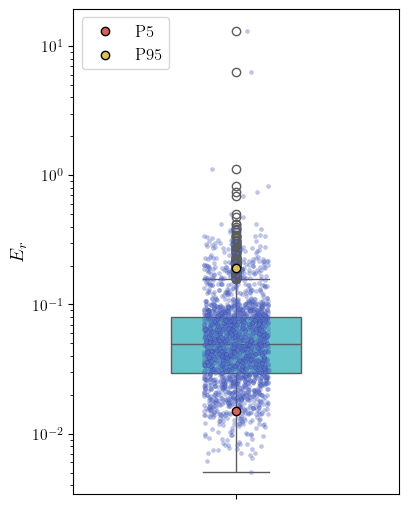

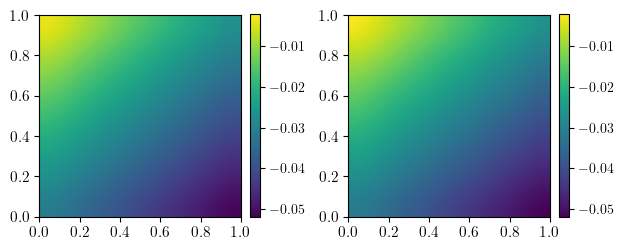

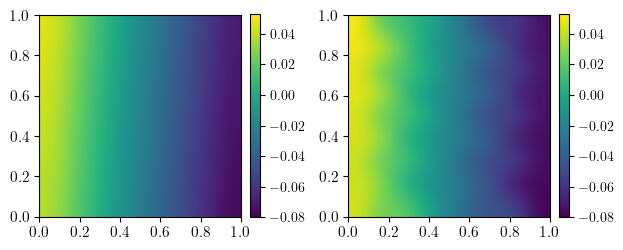

In [29]:
plot_boxplot_and_colormaps(validation_solution=qx_validation, predicted_solution=qx_prediction, variable='qx', problem='nonlinear_P4')

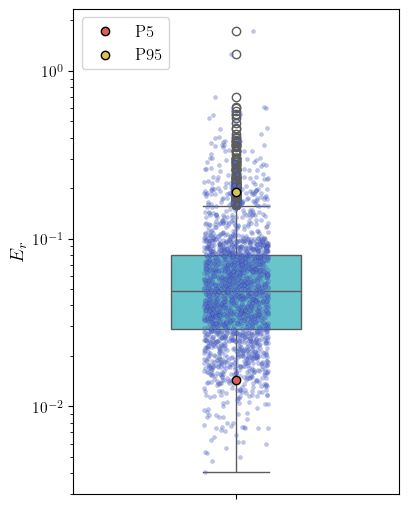

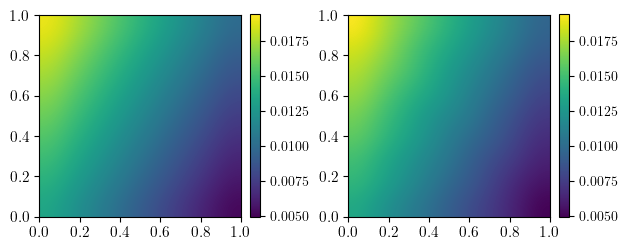

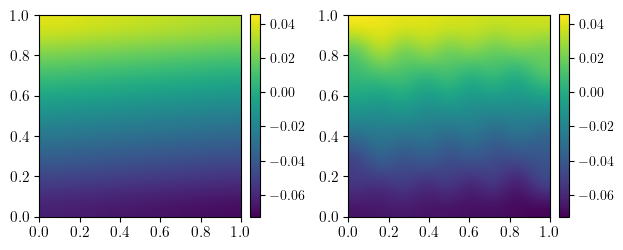

In [30]:
plot_boxplot_and_colormaps(validation_solution=qy_validation, predicted_solution=qy_prediction, variable='qy', problem='nonlinear_P4')